In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

## Lab 2: Ridge and Lasso

In [2]:
hitters=pd.read_csv('../data/Hitters.csv', index_col=0).dropna()
print(hitters.shape)
hitters.head()

(263, 20)


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [3]:
hitters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, Alan Ashby to Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 
d

In [4]:
# !cat ../data/Hitters.txt

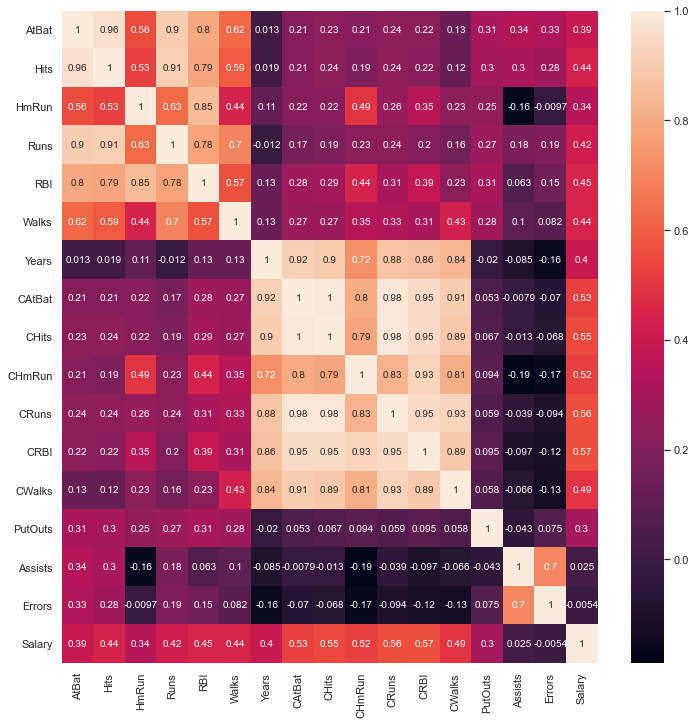

In [5]:
fig,ax = plt.subplots(1,1, figsize=(12,12))
sns.heatmap(hitters.corr(), annot=True, ax=ax);

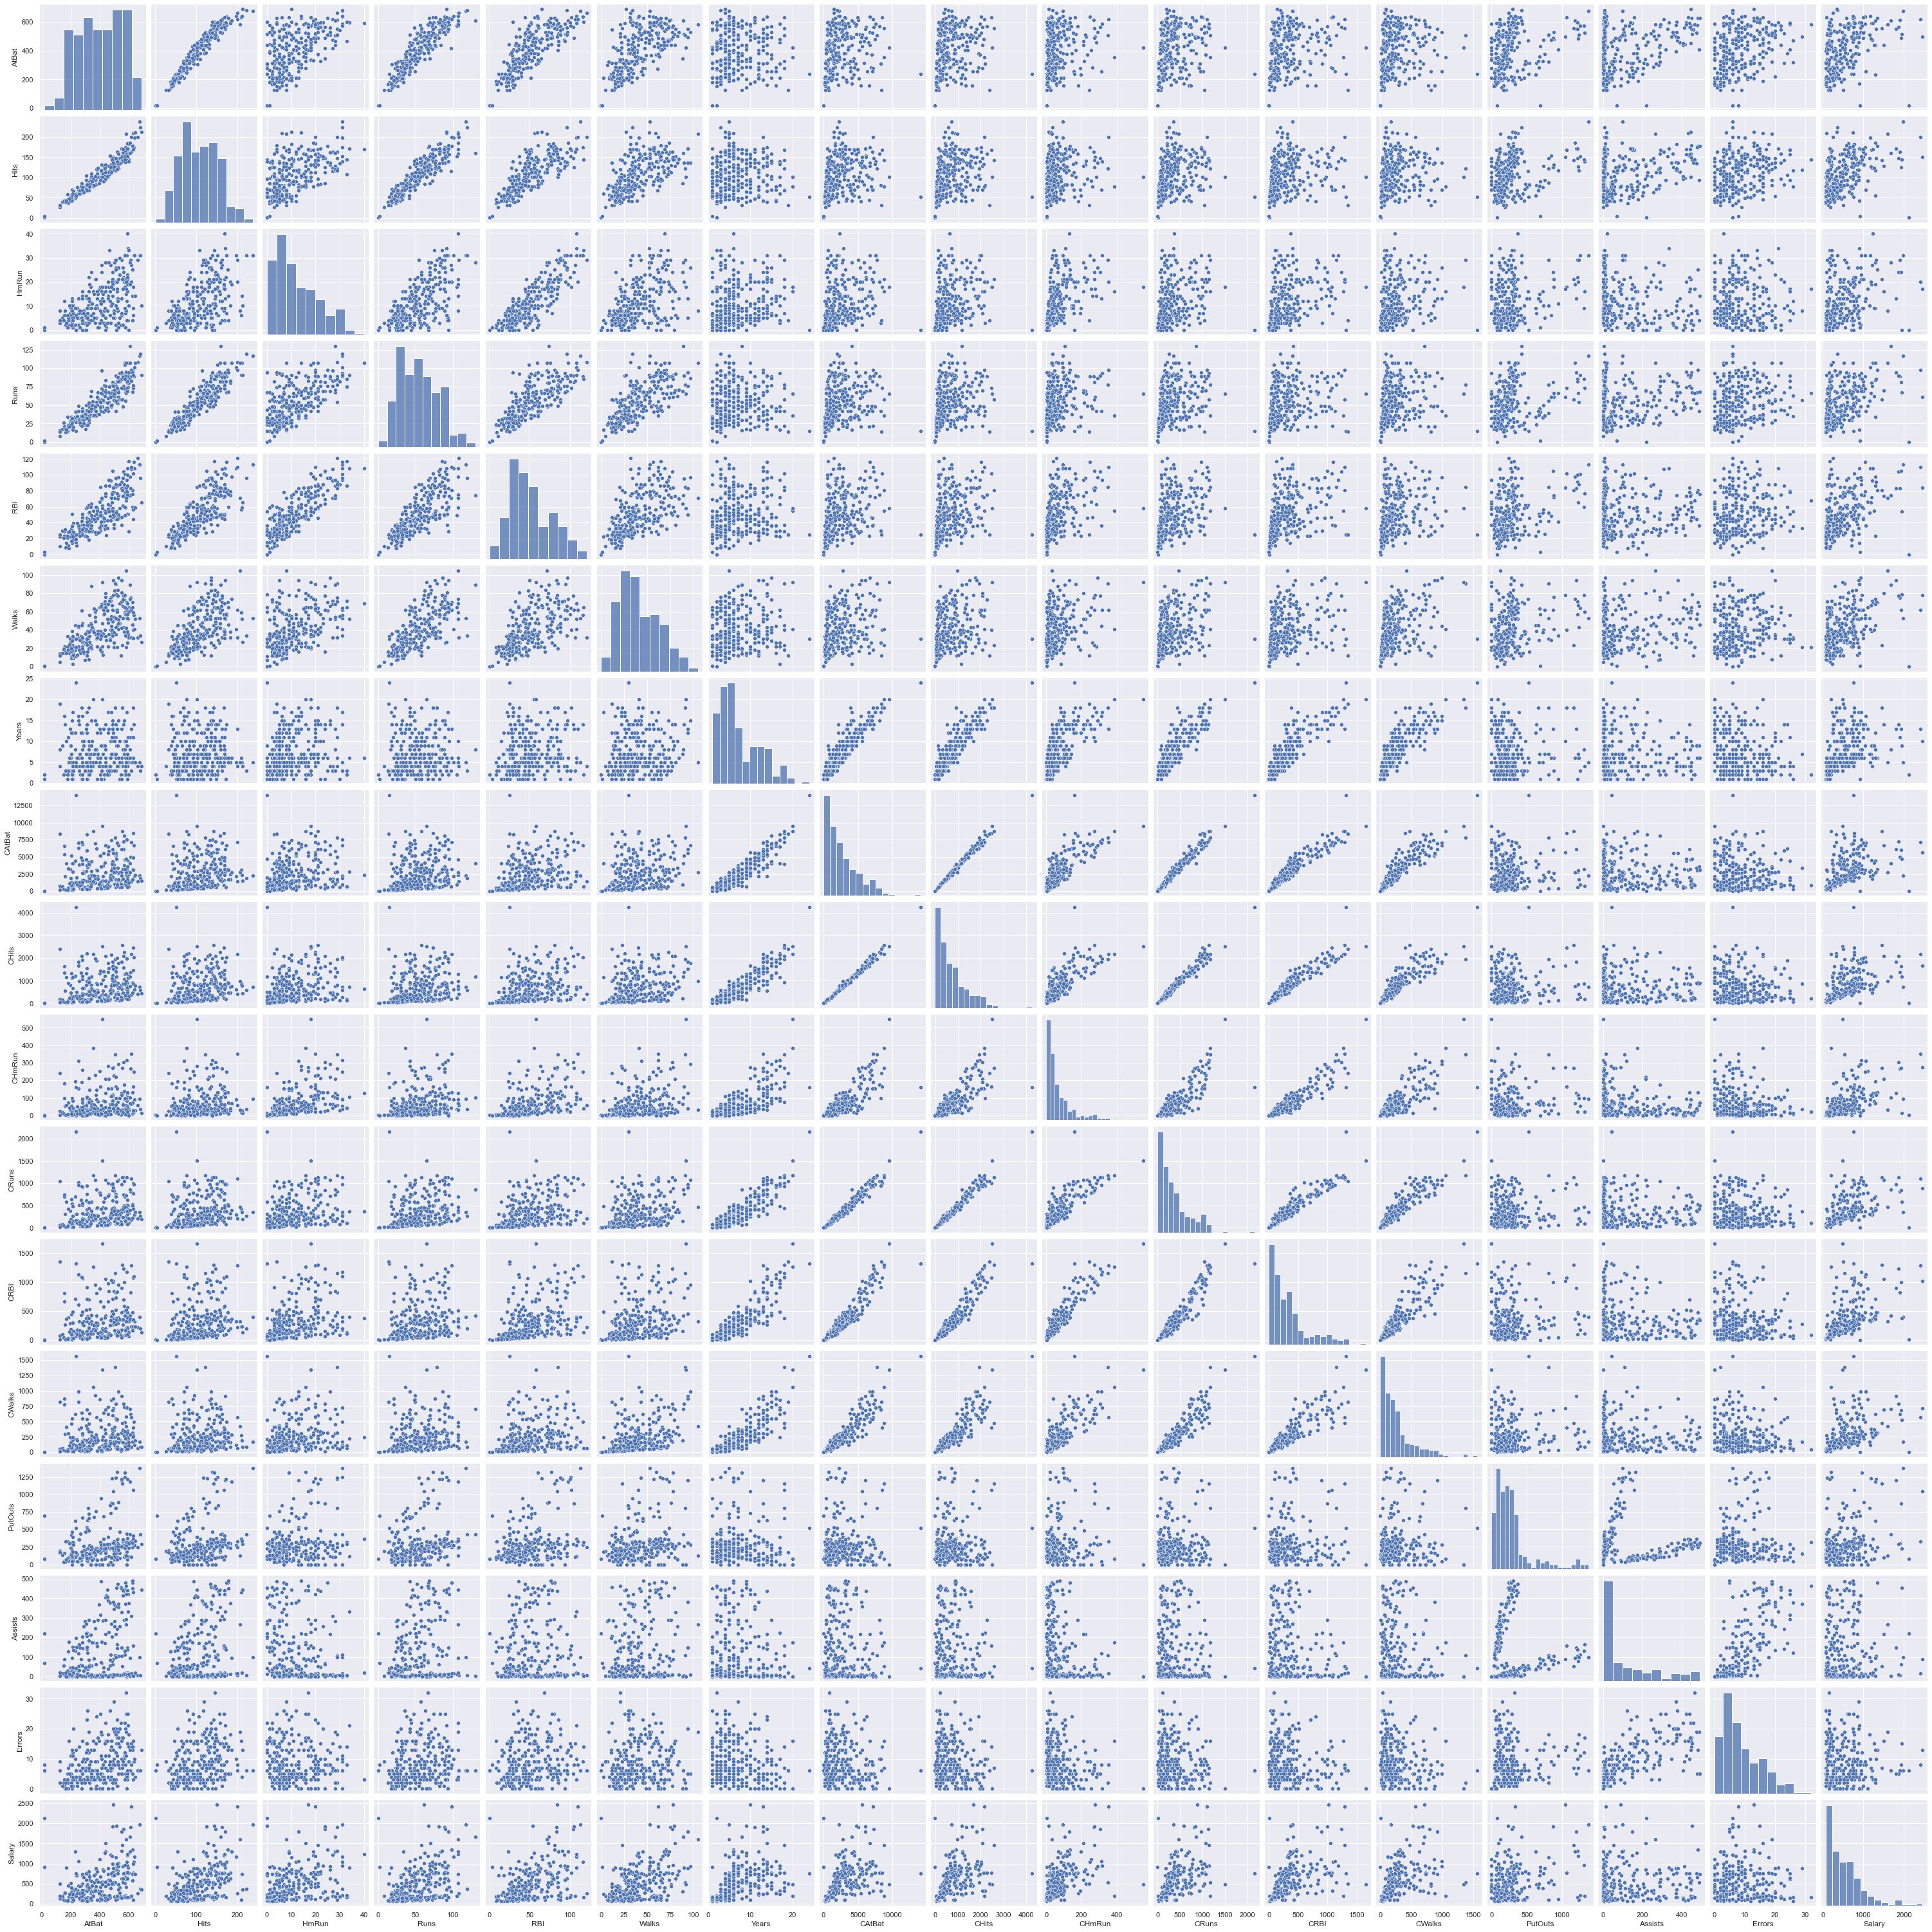

In [6]:
sns.pairplot(hitters);

### Ridge regression
source: https://nbviewer.jupyter.org/github/JWarmenhoven/ISL-python/blob/master/Notebooks/Chapter%206.ipynb
![title](../figures/Ridge_sklearn_vs_R.jpg)

#### Perform CV to pick the best alpha
There seems to be some collinearity in the data. This could cause problems with OLS linear regression. However, with Ridge regression, with a sufficiently large value of $lambda$, some of the coefficients should be set to zero. This should hopefully solve the collinearity problems. Choose $lambda$ value through cross-validation.

In [7]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline

In [8]:
# prepare the data
X = hitters.drop(columns='Salary')
y = hitters.Salary

cat_cols = list(X.columns[X.dtypes == 'object'])
num_cols = list(set(X.columns) ^ set(cat_cols))
print(cat_cols)
print(num_cols)

['League', 'Division', 'NewLeague']
['CAtBat', 'CRuns', 'Runs', 'Hits', 'CHits', 'AtBat', 'Assists', 'HmRun', 'CHmRun', 'RBI', 'Errors', 'Walks', 'PutOuts', 'Years', 'CWalks', 'CRBI']


In [9]:
X_cat = pd.get_dummies(X[cat_cols], drop_first=True)
X_cat.head()

,League_N,Division_W,NewLeague_N
Alan Ashby,1,1,1
Alvin Davis,0,1,0
Andre Dawson,1,0,1
Andres Galarraga,1,0,1
Alfredo Griffin,0,1,0


In [10]:
X_num = X[num_cols]
X_num = StandardScaler().fit_transform(X_num) # returns a ndarray
X_num = pd.DataFrame(X_num, columns=num_cols)
X_num.head()

,CAtBat,CRuns,Runs,Hits,CHits,AtBat,Assists,HmRun,CHmRun,RBI,Errors,Walks,PutOuts,Years,CWalks,CRBI
0,0.346791,-0.121671,-1.206112,-0.595675,0.174373,-0.602900,-0.523191,-0.528551,-0.002920,-0.522063,0.213352,-0.097527,1.221499,1.397893,0.435334,0.258966
1,-0.452865,-0.415105,0.441515,0.492260,-0.409892,0.512542,-0.253863,0.729966,-0.076054,0.794060,0.819964,1.609373,2.109109,-0.901200,0.010373,-0.199590
2,1.301558,1.412051,0.402286,0.736490,1.318174,0.628167,-0.744179,0.958788,1.898565,1.026317,-0.848219,-0.189792,-0.324661,0.770868,0.355654,1.572666
3,-0.990935,-0.947521,-0.617673,-0.462459,-0.960153,-0.562092,-0.543909,-0.185319,-0.697693,-0.367225,-0.696566,-0.512719,1.840678,-1.110209,-0.862315,-0.881228
4,0.766993,0.422846,0.755349,1.358167,0.634985,1.294712,2.087225,-0.871783,-0.612370,-0.018840,2.488147,-0.282057,-0.031177,0.770868,-0.251434,0.017294


In [11]:
X_num.describe().loc[['mean', 'std']]

,CAtBat,CRuns,Runs,Hits,CHits,AtBat,Assists,HmRun,CHmRun,RBI,Errors,Walks,PutOuts,Years,CWalks,CRBI
mean,5.572222e-17,3.968098e-17,-6.247643e-17,6.669781e-17,7.007491e-17,-3.377104e-18,-5.065656e-17,4.685732e-17,6.142108e-17,1.576686e-16,1.055345e-16,-7.176347e-18,9.730282e-17,-9.709175e-18,1.076188e-16,8.337226e-18
std,1.001907e+00,1.001907e+00,1.001907e+00,1.001907e+00,1.001907e+00,1.001907e+00,1.001907e+00,1.001907e+00,1.001907e+00,1.001907e+00,1.001907e+00,1.001907e+00,1.001907e+00,1.001907e+00,1.001907e+00,1.001907e+00


In [12]:
X_new = np.c_[X_num, X_cat]
# X_new[:5]

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(210, 19) (210,) (53, 19) (53,)


In [14]:
# use RidgeCV to pick the best alpha value
alphas=10**np.linspace(10, -2, 100)
ridge_cv = RidgeCV(alphas=alphas, normalize=False,
           cv=None, # performs LOO cv efficiently
           scoring='neg_mean_squared_error',
           store_cv_values=False, # if true, saves (n_samples, n_alphas) scores)
        )
ridge_cv.fit(X_new, y)
best_cv_alpha = ridge_cv.alpha_
print('Best alpha: ', best_cv_alpha, '\nbest score: ', ridge_cv.best_score_)

Best alpha:  3.5111917342151275 
best score:  -114287.18469541501


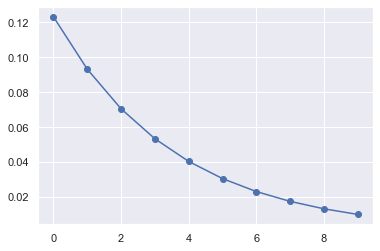

In [15]:
plt.plot(alphas[90:], 'b-o');

In [16]:
ridge_cv

RidgeCV(alphas=array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09, 2.47707636e+09, 1.87381742e+09, 1.41747416e+09,
       1.07226722e+09, 8.11130831e+08, 6.13590727e+08, 4.64158883e+08,
       3.51119173e+08, 2.65608778e+08, 2.00923300e+08, 1.51991108e+08,
       1.14975700e+08, 8.69749003e+07, 6.57933225e+07, 4.97702356e+07,
       3.76493581e+07, 2.84803587e+0...
       6.13590727e+00, 4.64158883e+00, 3.51119173e+00, 2.65608778e+00,
       2.00923300e+00, 1.51991108e+00, 1.14975700e+00, 8.69749003e-01,
       6.57933225e-01, 4.97702356e-01, 3.76493581e-01, 2.84803587e-01,
       2.15443469e-01, 1.62975083e-01, 1.23284674e-01, 9.32603347e-02,
       7.05480231e-02, 5.33669923e-02, 4.03701726e-02, 3.05385551e-02,
       2.31012970e-02, 1.74752840e-02, 1.32194115e-02, 1.00000000e-02]),
        scoring='neg_mean_squared_error')

In [17]:
# test error
from sklearn.metrics import mean_squared_error
ridge_reg = Ridge(alpha=best_cv_alpha).fit(X_train, y_train)
print('Train error: ', mean_squared_error(y_train, ridge_reg.predict(X_train)))
print('Test error: ', mean_squared_error(y_test, ridge_reg.predict(X_test)))

Train error:  90708.17242367029
Test error:  116833.71485674162


In [18]:
# let's do LOO and k-fold cv manually
from sklearn.model_selection import LeaveOneOut, KFold, cross_val_score

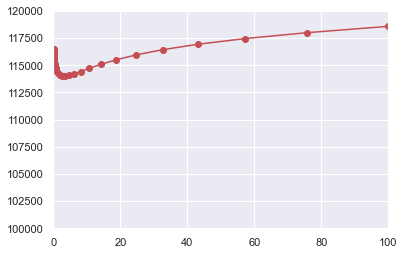

In [19]:
test_err_loo, test_err_kf, test_err = [], [], []
ridge_reg = Ridge()
for a in alphas:
    ridge_reg.set_params(alpha=a)
    cv_scores = cross_val_score(ridge_reg, X_new, y, scoring='neg_mean_squared_error', cv=10)
    test_err.append(np.mean(-cv_scores))
plt.plot(alphas, test_err, 'r-o', label='Test MSE')
plt.xlim([0, 100])
plt.ylim([100000, 120000]);

In [20]:
min_score = np.argmin(test_err)
alphas[min_score]

3.5111917342151275

#### How better is Ridge over OLS?

In [21]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression().fit(X_train, y_train)
print('Train error: ', mean_squared_error(y_train, lin_reg.predict(X_train)))
print('Test error: ', mean_squared_error(y_test, lin_reg.predict(X_test)))

Train error:  88443.87280114683
Test error:  115012.0839394434


Ridge doesn't seem to be performing all that better than OLS. What??? 

Let's look at Ridge scores for a higher regularization.

In [22]:
ridge_reg_100 = Ridge(alpha=100).fit(X_train, y_train)
print('Train error: ', mean_squared_error(y_train, ridge_reg_100.predict(X_train)))
print('Test error: ', mean_squared_error(y_test, ridge_reg_100.predict(X_test)))

Train error:  102698.99475149144
Test error:  135824.40814765307


### Lasso

In [23]:
lasso_cv = LassoCV(alphas=None, cv=10, max_iter=10000)
lasso_cv.fit(X_new, y)
best_alpha_lasso = lasso_cv.alpha_
print(best_alpha_lasso)

2.552820965069262


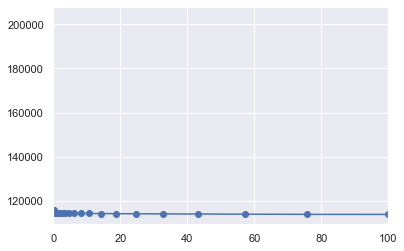

In [24]:
lasso_scores = np.mean(lasso_cv.mse_path_, axis=1)
plt.plot(alphas, lasso_scores, 'b-o')
plt.xlim([0, 100]);

In [25]:
lasso_reg = Lasso(alpha=best_alpha_lasso).fit(X_train, y_train)
print('Train error: ', mean_squared_error(y_train, lasso_reg.predict(X_train)))
print('Test error: ', mean_squared_error(y_test, lasso_reg.predict(X_test)))

Train error:  90593.41769525994
Test error:  119206.35010565487


In [26]:
lasso_reg.coef_ # how many coefficients are set to 0?

array([  -0.        ,  153.24367665,   25.69239178,  315.56506157,
          0.        , -284.6728217 ,   28.72203336,   -0.        ,
         48.51304204,    0.        ,  -21.89931013,   84.15026515,
         75.02588436,  -46.26495308,  -62.20867138,  106.21533142,
         24.98084686,  -75.32000179,    0.        ])

In [27]:
lasso_reg = Lasso(alpha=10).fit(X_train, y_train)
print('Train error: ', mean_squared_error(y_train, lasso_reg.predict(X_train)))
print('Test error: ', mean_squared_error(y_test, lasso_reg.predict(X_test)))

Train error:  100142.25052937021
Test error:  127919.29414093746


In [28]:
lasso_reg = Lasso(alpha=best_alpha_lasso).fit(X_new, y) # train on full data set
print('Train error: ', mean_squared_error(y_train, lasso_reg.predict(X_train)))
print('Test error: ', mean_squared_error(y_test, lasso_reg.predict(X_test)))

Train error:  91341.77894723795
Test error:  106756.95521131749


### Lasso vs. Ridge vs. OLS
It doesn't appear like neither Lasso nor Ridge seem to be performing better than OLS.

## Princiap Componnets Analysis (PCA) & Partial Lease Squares (PLS)

In [29]:
from sklearn.decomposition import PCA

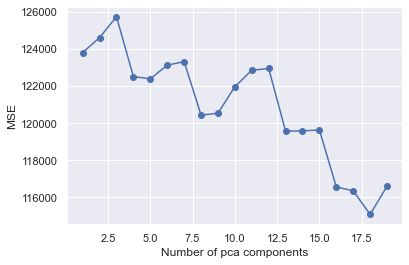

In [30]:
pca = PCA()
X_pca = pca.fit_transform(X_new)
lin_reg = LinearRegression()
pca_mse = []
n_components = len(X_pca[0])
for i in range(1, n_components+1):
    cv_scores = cross_val_score(lin_reg, X_pca[:, :i], y, cv=10, 
                                scoring='neg_mean_squared_error')
    pca_mse.append(np.mean(-cv_scores))
plt.plot(range(1, n_components+1), pca_mse, 'b-o')
plt.ylabel('MSE')
plt.xlabel('Number of pca components')
plt.show();

In [31]:
pca.explained_variance_

array([7.28361237e+00, 4.13209939e+00, 1.74570868e+00, 8.97345470e-01,
       7.04285646e-01, 5.17457643e-01, 4.21876329e-01, 2.52784454e-01,
       2.49572186e-01, 1.85225693e-01, 1.31033259e-01, 9.55560343e-02,
       6.13736618e-02, 5.25856413e-02, 3.31674242e-02, 2.78273362e-02,
       1.41312568e-02, 4.88054647e-03, 1.19148499e-03])

In [32]:
pca.explained_variance_ratio_

array([4.33246256e-01, 2.45786912e-01, 1.03838825e-01, 5.33762020e-02,
       4.18925533e-02, 3.07795878e-02, 2.50941883e-02, 1.50362091e-02,
       1.48451359e-02, 1.10176564e-02, 7.79416397e-03, 5.68389585e-03,
       3.65064859e-03, 3.12791663e-03, 1.97287577e-03, 1.65523488e-03,
       8.40560122e-04, 2.90306290e-04, 7.08723070e-05])

In [33]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 43.32,  67.9 ,  78.28,  83.62,  87.81,  90.89,  93.4 ,  94.9 ,
        96.38,  97.48,  98.26,  98.83,  99.2 ,  99.51,  99.71,  99.88,
        99.96,  99.99, 100.  ])

In [34]:
# pca test error
pca = PCA()
lin_reg = LinearRegression()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
test_mse = []
for i in range(1, n_components+1):
    lin_reg.fit(X_train_pca[:, :i], y_train)
    test_mse.append(mean_squared_error(y_test, lin_reg.predict(X_test_pca[:, :i])))

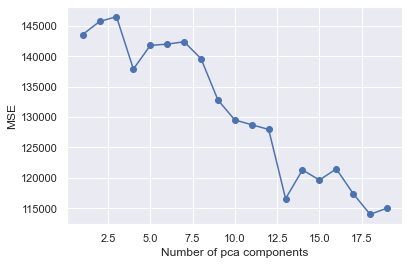

In [35]:
plt.plot(range(1, n_components+1), test_mse, 'b-o')
plt.ylabel('MSE')
plt.xlabel('Number of pca components')
plt.show();